# 환경 설정

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/NLP_TP')

Mounted at /content/drive


In [3]:
#필요 패키지 설치
!pip install transformers==4.52.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 97.7 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.4
    Uninstalling transformers-4.52.4:
      Successfully uninstalled transformers-4.52.4


In [4]:
#필수 라이브러리 임포트 및 정의
import importlib
import CustomTokenizer
importlib.reload(CustomTokenizer)
from CustomTokenizer import CustomTokenizer

# 데이터셋 탐색

In [5]:
PATH_DATASET = '/content/drive/MyDrive/NLP_TP/5차년도_2차.csv'

import pandas as pd

df = pd.read_csv(PATH_DATASET, encoding = 'cp949')

# Label Encoding
label_map = {
    "fear": 0,
    "surprise": 1,
    "angry": 2,
    "sadness": 3,
    "neutral": 4,
    "happiness": 5,
    "disgust": 6
}

df ['감정']= df["상황"].map(label_map)

## 시각화 (Visualization)

In [6]:
input_data = df[["발화문","감정"]]

input_data

,발화문,감정
0,헐! 나 이벤트에 당첨 됐어.,5
1,내가 좋아하는 인플루언서가 이벤트를 하더라고. 그래서 그냥 신청 한번 해봤지.,5
2,"한 명 뽑는 거였는데, 그게 바로 내가 된 거야.",5
3,"당연히 마음에 드는 선물이니깐, 이벤트에 내가 신청 한번 해본 거지. 비싼 거야. ...",5
4,에피타이저 정말 좋아해. 그 것도 괜찮은 생각인 것 같애.,4
...,...,...
19369,나 엘리베이터에 갇혔어.,0
19370,하지만 기분이 나쁜 걸 어떡해?,2
19371,자취방 엘리베이턴데 정전인가봐.,0
19372,나 드디어 프로젝트 끝났어!,5


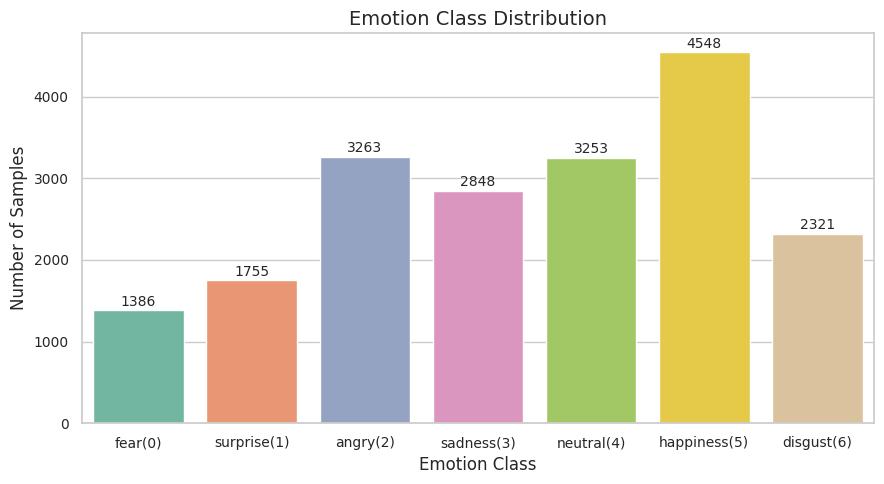

In [7]:
#데이터 EDA. 분포 확인.
import matplotlib.pyplot as plt
import seaborn as sns

# seaborn 스타일 설정
sns.set(style="whitegrid", palette="Set2")

# 감정별 개수 세기
emotion_counts = input_data['감정'].value_counts().sort_index()
emotion_df = emotion_counts.reset_index()
emotion_df.columns = ['emotion', 'count']

# 색상 지정 (원하면 변경 가능)
colors = sns.color_palette("Set2", 7)

# 시각화
plt.figure(figsize=(9, 5))
bars = sns.barplot(
    data=emotion_df,
    x='emotion', y='count',
    hue='emotion',
    palette='Set2',
    legend=False
)

# 바 위에 숫자 라벨 추가
for bar in bars.patches:
    height = bar.get_height()
    bars.annotate(f'{int(height)}',
                  xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 1),  # 위쪽에 약간 띄워서 표시
                  textcoords='offset points',
                  ha='center', va='bottom',
                  fontsize=10)

# 라벨 & 제목 설정
plt.xlabel("Emotion Class", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.title("Emotion Class Distribution", fontsize=14)
plt.xticks(ticks=range(7), labels=[
    "fear(0)", "surprise(1)", "angry(2)",
    "sadness(3)", "neutral(4)", "happiness(5)", "disgust(6)"
], fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


## 학습/평가 데이터 분할 (Train/Test Split)

In [8]:
from sklearn.model_selection import train_test_split

x_col = '발화문'
y_col = '감정'

trval_X, test_X, trval_y, test_y = train_test_split(
    input_data[x_col].tolist(), input_data[y_col].tolist(),
    test_size=0.05, stratify=input_data[y_col], random_state=42)

from sklearn.model_selection import train_test_split
train_X, valid_X, train_y, valid_y = train_test_split(
    trval_X, trval_y, test_size=0.05, stratify=trval_y, random_state=42)

print(f"            x      y")
print(f"train size: {len(train_X):<5}  {len(train_y):<5}")
print(f"valid size: {len(valid_X):<5}  {len(valid_y):<5}")
print(f"test size : {len(test_X):<5}  {len(test_y):<5}")

            x      y
train size: 17484  17484
valid size: 921    921  
test size : 969    969  


<Figure size 1000x600 with 0 Axes>

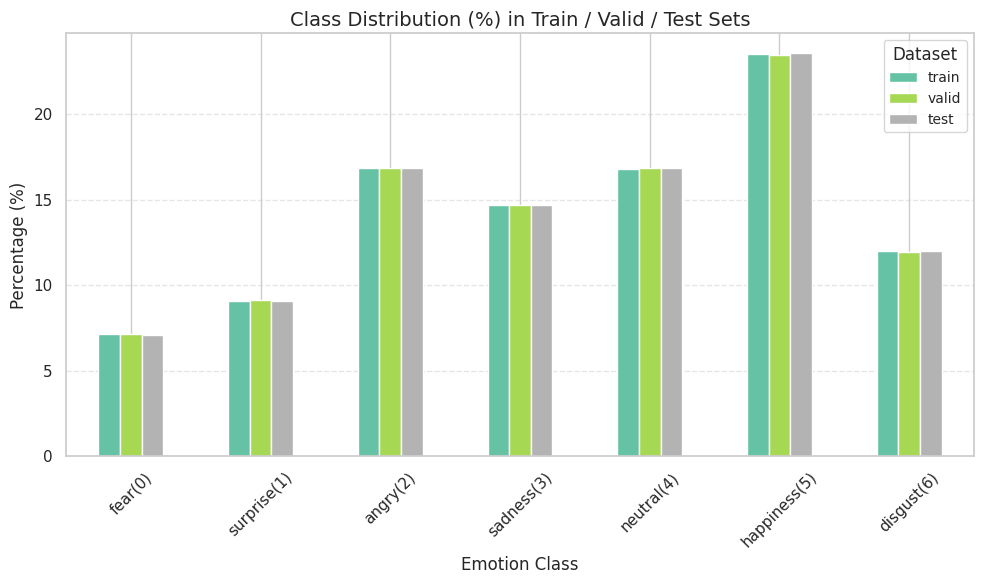

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 데이터프레임으로 정리
dist_df = pd.DataFrame({
    'train': pd.Series(train_y).value_counts(normalize=True).sort_index(),
    'valid': pd.Series(valid_y).value_counts(normalize=True).sort_index(),
    'test': pd.Series(test_y).value_counts(normalize=True).sort_index()
})

# 퍼센트로 변환
dist_df *= 100

# 시각화
plt.figure(figsize=(10, 6))
dist_df.plot(kind='bar', rot=0, figsize=(10,6), colormap='Set2')
plt.title('Class Distribution (%) in Train / Valid / Test Sets', fontsize=14)
plt.xlabel('Emotion Class', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.legend(title='Dataset', fontsize=10)
plt.xticks(ticks=range(7), labels=[
    "fear(0)", "surprise(1)", "angry(2)", "sadness(3)",
    "neutral(4)", "happiness(5)", "disgust(6)"], rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


# Custom Tokenizer

In [14]:
import json
from collections import Counter
import torch
import os

class CustomTokenizer:
    # vocab, 특수 토큰 등 초기화
    def __init__(self, vocab_size=3000, tokenizer_type ='freq',n=2):
        self.vocab_size = vocab_size
        self.vocab={}
        self.n = n  # n-gram 설정용 파라미터 추가
        self.special_tokens_map = {
        '[UNK]': 0,
        '[PAD]': 1,
        '[CLS]': 2,
        '[SEP]': 3,
        '[MASK]': 4,
        }

        self.special_tokens = list(self.special_tokens_map.keys())

        for token, idx in self.special_tokens_map.items():
            self.vocab[token]=idx

        #어떤 방식으로 vocab을 생성할건지 설정. 기본값 = 빈도로 설정. option으로 설정.
        self.tokenizer_type = tokenizer_type

    # 단순 단어 빈도 기반 vocab 생성
    def train_freq(self, corpus):
        """빈도 기반 vocab 생성"""

        # 1. 토큰의 빈도수 count
        count = Counter()
        for line in corpus:
            tokens = self.tokenize(line) # text.split()
            count.update(tokens)

        # 2. 자주 등장한 토큰을 vocab_size 에 맞게 추가.
        num_add = self.vocab_size - len(self.special_tokens)
        for token, _ in count.most_common(num_add): #most_common(num_add)는 가장 많이 등장한 토큰 n개를 뽑는 함수.
            if token not in self.vocab:
                self.vocab[token] = len(self.vocab)

        print(f"[train_freq] vacab 생성 완료. 총 {len(self.vocab)}개 토큰 등록.")
        self.save_tokenizer(f"./tokenizers/{self.tokenizer_type}")


    def train_bpe(self, corpus):
        """BPE 원리 기반 서브워드 vocab 생성"""

        # 1. 초기 서브워드 카운트 (공백 있는 버전으로 저장)
        subword_counter = Counter()
        for line in corpus:
            tokens = self.tokenize(line)  # e.g., ['나', '는', '학', '교', '에', '</w>']
            joined = ' '.join(tokens)     # '나 는 학 교 에 </w>'
            subword_counter[joined] += 1

        # 2. BPE 병합 반복
        self.bpe_merges = []
        num_add = self.vocab_size - len(self.vocab)
        while len(self.vocab) < self.vocab_size and len(self.bpe_merges) < num_add:
            # 빈도 높은 쌍 탐색
            pair_counter = Counter()
            for token_seq, freq in subword_counter.items():
                symbols = token_seq.split()
                for i in range(len(symbols) - 1):
                    pair = (symbols[i], symbols[i + 1])
                    pair_counter[pair] += freq

            if not pair_counter:
                break

            best_pair = pair_counter.most_common(1)[0][0]
            self.bpe_merges.append(best_pair)

            # 병합 적용
            new_counter = Counter()
            pattern = ' '.join(best_pair)
            replacement = ''.join(best_pair)
            for token_seq, freq in subword_counter.items():
                new_token_seq = token_seq.replace(pattern, replacement)
                new_counter[new_token_seq] += freq
            subword_counter = new_counter

            # vocab 추가
            if replacement not in self.vocab:
                self.vocab[replacement] = len(self.vocab)

        print(f"[train_bpe] vocab 생성 완료. 총 {len(self.vocab)}개 토큰 등록.")
        self.save_tokenizer(f"./tokenizers/{self.tokenizer_type}")


    def train_ngram(self, corpus):
        """n-gram 기반 vocab 생성"""
        count = Counter()
        for line in corpus:
            tokens = self.tokenize_ngram(line, self.n)
            count.update(tokens)

        num_add = self.vocab_size - len(self.special_tokens)
        for token, _ in count.most_common(num_add):
            if token not in self.vocab:
                self.vocab[token] = len(self.vocab)

        print(f"[train_ngram] vocab 생성 완료. 총 {len(self.vocab)}개 토큰 등록.")
        self.save_tokenizer(f"./tokenizers/{self.tokenizer_type}")



    # 문장 토큰화
    def tokenize(self, text):
        if self.tokenizer_type == 'freq':
            return text.strip().split()

        elif self.tokenizer_type == 'bpe':
            tokens = []
            for word in text.strip().split():
               chars = list(word) + ['</w>']
               tokens.extend(chars)
            return tokens

        elif self.tokenizer_type == 'ngram':
            return self.tokenize_ngram(text, self.n)

        else:
            raise ValueError(f"[tokenize] 알 수 없는 tokenizer_type: {self.tokenizer_type}")

    def apply_bpe_merges(self, tokens):
        merged = tokens[:]

        for merge_pair in self.bpe_merges:
            i = 0
            while i < len(merged) - 1:
                if (merged[i], merged[i + 1]) == merge_pair:
                    merged = merged[:i] + [''.join(merge_pair)] + merged[i + 2:]
                    i = max(i - 1, 0) # 병합 후 앞에서부터 다시 확인 (연쇄 병합 대비)

                else:
                    i += 1

        return merged


    def tokenize_ngram(self, text, n):
        words = text.strip().split()  # 띄어쓰기 기준으로 단어 추출
        tokens = []
        for i in range(len(words) - n + 1):
            tokens.append(' '.join(words[i:i+n]))  # 예: "나는 오늘", "오늘 학교"
        return tokens


    def encode(self, text, text_pair=None, max_length=32, padding=True, truncation=True):
        """"
        주어진 텍스트를 BERT 모델 입력 형식 (input_ids, attention_mask, token_type_ids)으로 인코딩한다.

        Args:
            text (str): 입력 텍스트. 하나 이상의 문장으로 구성될 수 있음.
            text_pair (str, optional): 두 번째 문장. 기본값은 None. 사용하지 않으면 단일 문장 처리됨.
            max_length (int): 출력 시퀀스의 최대 길이. 기본값은 32.
            truncation (bool): max_length보다 길 경우 자를지 여부. 기본값은 True.

        Returns:
            Tuple[List[int], List[int], List[int]]:
                - input_ids: 토큰을 vocab 인덱스로 매핑한 리스트.
                - attention_mask: 실제 토큰은 1, 패딩된 토큰은 0으로 표시.
                - token_type_ids: 문장 구분을 위한 타입 인덱스. 현재 모두 0으로 구성됨.

        Notes:
            - BPE 토크나이저를 사용하는 경우, 토큰화 후 merge 규칙이 적용된다.
            - 입력 텍스트는 '[CLS]'로 시작하고 각 문장은 '[SEP]'로 끝난다.
            - text_pair가 있을 경우 두 번째 문장도 '[SEP]'로 끝나며 token_type_id는 1로 설정된다.
            - vocab에 없는 토큰은 '[UNK]'로 처리된다.
            - 패딩은 '[PAD]'로 채워지며 attention_mask에서 0으로 처리된다.

        Preconditions:
            - self.vocab은 학습이 완료되어 있어야 함.
            - self.tokenizer_type은 'bpe', 'freq', 'ngram' 중 하나여야 함.
            - text는 str 타입이어야 하며 None이 아니어야 함.

        Postconditions:
            - 리턴되는 세 개의 리스트 길이는 모두 max_length와 동일함.
            - 인코딩된 input_ids에는 반드시 '[CLS]'(2)와 '[SEP]'(3) 토큰이 포함되어야 함.
            - attention_mask는 input_ids에서 실제 토큰은 1, 패딩은 0으로 표시됨.
            - token_type_ids는 현재는 모든 문장에 대해 0으로 고정됨.
        """
        # 1. 토큰화
        tokens_a = self.tokenize(text)
        tokens_b = self.tokenize(text_pair) if text_pair else []

        # 1.1 BPE 병합 적용
        if self.tokenizer_type == 'bpe':
            tokens_a = self.apply_bpe_merges(tokens_a)
            if text_pair:
                tokens_b = self.apply_bpe_merges(tokens_b)

        # 2. [CLS], [SEP] 추가
        tokens = ['[CLS]'] + tokens_a + ['[SEP]']
        token_type_ids = [0] * len(tokens)

        if text_pair:
            tokens += tokens_b + ['[SEP]']
            token_type_ids += [1] * (len(tokens_b) + 1)

        # 3. 토큰 → ID (vocab에 없으면 [UNK])
        input_ids = [self.vocab.get(tok, self.vocab['[UNK]']) for tok in tokens]

        return tokens, input_ids#, attention_mask, token_type_ids

    # tokenizer(text) 호출 시 동작

    def __call__(self, text, text_pair=None, max_length=32, return_tensors='pt', padding=True, truncation=True):
        """
        텍스트를 BERT 입력 형식으로 인코딩하고, 딕셔너리 형태로 반환한다.
        tokenizer(text)처럼 바로 호출할 수 있도록 정의된 special method이다.

        Args:
            text (str): 입력 문장.
            text_pair (str, optional): 두 번째 문장. 문장쌍 입력이 필요한 경우 사용.
            max_length (int): 출력 길이 제한. 기본값은 32.
            return_tensors (str): 반환 타입. 'pt'는 PyTorch 텐서 형태로 반환. 'np' 또는 'list'는 미지원 (현재는 'pt'만 지원).

        Returns:
            dict: 다음 key를 포함한 딕셔너리 반환
                - 'input_ids': torch.LongTensor of token ids
                - 'attention_mask': torch.LongTensor (1은 실제 토큰, 0은 패딩)
                - 'token_type_ids': torch.LongTensor (문장 구분용, 현재 두 번째 문장이 있을 경우 1로 설정됨)

        Notes:
            - 내부적으로 self.encode()를 호출하여 토큰 인덱스를 생성한다.
            - return_tensors가 'pt'인 경우 PyTorch 텐서로 변환한다.
            - 향후 TensorFlow, NumPy 대응은 확장 가능.

        Preconditions:
            - self.encode() 함수가 정상 작동해야 함.
            - text는 str 타입이어야 하며 None이 아니어야 함.
            - vocab이 사전에 학습되어 있어야 함.

        Postconditions:
            - 반환되는 딕셔너리는 3개의 key ('input_ids', 'attention_mask', 'token_type_ids')를 포함.
            - 각 값은 동일한 길이의 torch.Tensor로 구성됨.
        """
        #input_ids, attention_mask, token_type_ids = self.encode(text, text_pair, max_length)
        # input_ids, attention_mask, token_type_ids = self.encode(
        #     text, text_pair, max_length=max_length, padding=padding, truncation=truncation
        # )

        tokens, input_ids = self.encode(
            text, text_pair, max_length=max_length, padding=padding, truncation=truncation
        )

        # 4. attention_mask
        attention_mask = [1] * len(input_ids)

        # 5. 길이 맞추기
        token_type_ids = [0] * len(tokens)

        if padding and len(input_ids) < max_length:
            pad_len = max_length - len(input_ids)
            input_ids += [self.vocab['[PAD]']] * pad_len
            attention_mask += [0] * pad_len
            token_type_ids += [0] * pad_len

        elif truncation:
            input_ids = input_ids[:max_length]
            attention_mask = attention_mask[:max_length]
            token_type_ids = token_type_ids[:max_length]

        else:
            raise ValueError("길이 초과: truncation=False일 때 max_length보다 긴 입력입니다.")


        if return_tensors == 'pt':
            return {
                'input_ids': torch.tensor([input_ids]),
                'attention_mask': torch.tensor([attention_mask]),
                'token_type_ids': torch.tensor([token_type_ids])
            }
        else:
            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'token_type_ids': token_type_ids
            }

    # 숫자 → 텍스트 복원
    def decode(self, input_ids):
        """
        숫자 ID 시퀀스를 원래 텍스트로 디코딩한다.

        Args:
            input_ids (List[int]): 토큰 ID 리스트. 일반적으로 모델 출력이나 tokenizer.encode() 결과.

        Returns:
            str: 복원된 자연어 문장.

        Process:
            1. input_ids를 토큰 문자열로 변환 (ID → 토큰)
            2. [PAD], [CLS], [SEP], [UNK] 등 특수 토큰 제거
            3. BPE 토크나이저일 경우, </w>로 끝나는 서브워드들을 공백 기준으로 재결합
            4. freq 방식일 경우, 단순 공백 연결
            5. ngram 방식일 경우, 처음 토큰은 그대로 사용하고 이후 n-1개의 중복을 제거한 방식으로 문장 복원

        Notes:
            - BPE의 경우 </w>는 서브워드 경계를 의미하며, 이를 기준으로 단어 경계를 복원함.
            - vocab이 존재하지 않거나, 잘못된 input_ids가 들어오면 [UNK]로 복원될 수 있음.

        Preconditions:
            - self.vocab은 학습되어 있어야 하며, input_ids 내 ID들은 해당 vocab에 존재하거나 예외처리 되어야 함.
            - self.special_tokens는 [PAD], [CLS], [SEP], [UNK], [MASK] 등을 포함해야 함.

        Postconditions:
            - 출력 문자열은 사람이 읽을 수 있는 형태의 문장임 (완전한 원문 복원은 아님).
        """
        # 1. ID → 토큰
        inv_vocab = {v: k for k, v in self.vocab.items()}
        tokens = [inv_vocab.get(i, '[UNK]') for i in input_ids]

        # 2. 특수 토큰 제거
        tokens = [t for t in tokens if t not in self.special_tokens]

        # 3. 조건 분기 처리
        if self.tokenizer_type == 'bpe':
            text = ''
            for token in tokens:
                if token.endswith('</w>'):
                    text += token.replace('</w>', '') + ' '
                else:
                    text += token
            return text.strip()

        elif self.tokenizer_type == 'ngram':
        # 중복 제거 방식 (n-1 만큼 겹치는 부분 고려)
            n = self.n
            if not tokens:
                return ""
            result = tokens[0]
            for token in tokens[1:]:
                if len(token) > 0:
                    result += token[-1]  # 마지막 글자만 추가
            return result

        elif self.tokenizer_type == 'freq':  # freq방식
            return ' '.join(tokens).strip()

    def save_tokenizer(self, save_dir):
        """vocab과 BPE merges를 디렉토리에 저장"""
        os.makedirs(save_dir, exist_ok=True)

        # vocab 저장
        vocab_path = os.path.join(save_dir, 'vocab.json')
        with open(vocab_path, 'w', encoding='utf-8') as f:
            json.dump(self.vocab, f, ensure_ascii=False, indent=2)

        print(f"[save_tokenizer] vocab 저장 완료 -> {vocab_path}")

        # BPE인 경우 병합 규칙도 저장
        if self.tokenizer_type == 'bpe' and hasattr(self, 'bpe_merges'):
            merges_path = os.path.join(save_dir, 'merges.txt')
            with open(merges_path, 'w', encoding='utf-8') as f:
                for pair in self.bpe_merges:
                    f.write(f"{pair[0]} {pair[1]}\n")
            print(f"[save_tokenizer] merges 저장 완료 -> {merges_path}")


    def load_tokenizer(self, load_dir):
        """디렉토리에서 vocab과 merges를 로드"""
        vocab_path = os.path.join(load_dir, 'vocab.json')
        with open(vocab_path, 'r', encoding='utf-8') as f:
            self.vocab = json.load(f)

        print(f"[load_tokenizer] vocab 로드 완료 -> {vocab_path}")

        # BPE인 경우 병합 규칙도 로드
        if self.tokenizer_type == 'bpe':
            merges_path = os.path.join(load_dir, 'merges.txt')
            self.bpe_merges = []
            with open(merges_path, 'r', encoding='utf-8') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 2:
                        self.bpe_merges.append((parts[0], parts[1]))
            print(f"[load_tokenizer] merges 로드 완료 -> {merges_path}")

# Vocab 생성

## 말뭉치(corpus) 구성

In [15]:
corpus = input_data['발화문'].tolist()
print(len(corpus))
corpus[:3]

19374


['헐! 나 이벤트에 당첨 됐어.',
 '내가 좋아하는 인플루언서가 이벤트를 하더라고. 그래서 그냥 신청 한번 해봤지.',
 '한 명 뽑는 거였는데, 그게 바로 내가 된 거야.']

## 빈도 기반(Freq) Vocab 생성

In [43]:
custom_tokenizer_freq = {1000: None, 5000: None, 10000: None}

for key in custom_tokenizer_freq.keys():
  custom_tokenizer_freq[key] = CustomTokenizer(vocab_size=key, tokenizer_type='freq')
  path = f'/content/drive/MyDrive/NLP_TP/tokenizers/freq/vocab_size_{key}'

  if os.path.exists(path):
    custom_tokenizer_freq[key].load_tokenizer(path)
  else:
    custom_tokenizer_freq[key].train_freq(corpus)
    custom_tokenizer_freq[key].save_tokenizer(f'/content/drive/MyDrive/NLP_TP/tokenizers/freq/vocab_size_{key}')

  for token, idx in custom_tokenizer_freq[key].vocab.items():
      print(f"{idx:>2} : {token}")
      if idx == 10:
        print('-'*30)
        break

[load_tokenizer] vocab 로드 완료 -> /content/drive/MyDrive/NLP_TP/tokenizers/freq/vocab_size_1000/vocab.json
 0 : [UNK]
 1 : [PAD]
 2 : [CLS]
 3 : [SEP]
 4 : [MASK]
 5 : 나
 6 : 너무
 7 : 내가
 8 : 것
 9 : 같아.
10 : 안
------------------------------
[load_tokenizer] vocab 로드 완료 -> /content/drive/MyDrive/NLP_TP/tokenizers/freq/vocab_size_5000/vocab.json
 0 : [UNK]
 1 : [PAD]
 2 : [CLS]
 3 : [SEP]
 4 : [MASK]
 5 : 나
 6 : 너무
 7 : 내가
 8 : 것
 9 : 같아.
10 : 안
------------------------------
[load_tokenizer] vocab 로드 완료 -> /content/drive/MyDrive/NLP_TP/tokenizers/freq/vocab_size_10000/vocab.json
 0 : [UNK]
 1 : [PAD]
 2 : [CLS]
 3 : [SEP]
 4 : [MASK]
 5 : 나
 6 : 너무
 7 : 내가
 8 : 것
 9 : 같아.
10 : 안
------------------------------


## n-gram 기반 Vocab 생성

In [44]:
n_gram_idxs = [2, 3, 4]
custom_tokenizer_n_gram = {
    1000: [None]*6,
    5000: [None]*6,
    10000: [None]*6
}

for idx in n_gram_idxs:
    for key in custom_tokenizer_n_gram.keys():
        temp_tokenizer = CustomTokenizer(vocab_size=key, tokenizer_type='ngram', n=idx)

        path = f'/content/drive/MyDrive/NLP_TP/tokenizers/n_gram/vocab_size_{key}_n_gram_{idx}'

        if os.path.exists(path):
          temp_tokenizer.load_tokenizer(path)
        else:
          temp_tokenizer.train_ngram(corpus)

        custom_tokenizer_n_gram[key][idx] = temp_tokenizer
        custom_tokenizer_n_gram[key][idx].save_tokenizer(f'/content/drive/MyDrive/NLP_TP/tokenizers/n_gram/vocab_size_{key}_n_gram_{idx}')

        print(f"\n[vocab size: {key}, n_gram idx: {idx}] 상위 10개 vocab")
        for token, id_ in temp_tokenizer.vocab.items():
            print(f"{id_:>2} : {token}")
            if id_ == 10:
                print('-'*30)
                break

[load_tokenizer] vocab 로드 완료 -> /content/drive/MyDrive/NLP_TP/tokenizers/n_gram/vocab_size_1000_n_gram_2/vocab.json
[save_tokenizer] vocab 저장 완료 -> /content/drive/MyDrive/NLP_TP/tokenizers/n_gram/vocab_size_1000_n_gram_2/vocab.json

[vocab size: 1000, n_gram idx: 2] 상위 10개 vocab
 0 : [UNK]
 1 : [PAD]
 2 : [CLS]
 3 : [SEP]
 4 : [MASK]
 5 : 것 같아.
 6 : 나 오늘
 7 : 오늘 짭새가
 8 : 너무 우울해.
 9 : 나 너무
10 : 궁금해서 구경
------------------------------
[load_tokenizer] vocab 로드 완료 -> /content/drive/MyDrive/NLP_TP/tokenizers/n_gram/vocab_size_5000_n_gram_2/vocab.json
[save_tokenizer] vocab 저장 완료 -> /content/drive/MyDrive/NLP_TP/tokenizers/n_gram/vocab_size_5000_n_gram_2/vocab.json

[vocab size: 5000, n_gram idx: 2] 상위 10개 vocab
 0 : [UNK]
 1 : [PAD]
 2 : [CLS]
 3 : [SEP]
 4 : [MASK]
 5 : 것 같아.
 6 : 나 오늘
 7 : 오늘 짭새가
 8 : 너무 우울해.
 9 : 나 너무
10 : 궁금해서 구경
------------------------------
[load_tokenizer] vocab 로드 완료 -> /content/drive/MyDrive/NLP_TP/tokenizers/n_gram/vocab_size_10000_n_gram_2/vocab.json
[save_token

## BPE 기반 Vocab 생성

In [45]:
custom_tokenizer_bpe = {1000: None, 5000: None, 10000: None}

for key in custom_tokenizer_bpe.keys():
  custom_tokenizer_bpe[key] = CustomTokenizer(vocab_size=key, tokenizer_type='bpe')

  path = f'/content/drive/MyDrive/NLP_TP/tokenizers/bpe/vocab_size_{key}'

  if os.path.exists(path):
    custom_tokenizer_bpe[key].load_tokenizer(path)
  else:
    custom_tokenizer_bpe[key].train_bpe(corpus)
  custom_tokenizer_bpe[key].save_tokenizer(f'/content/drive/MyDrive/NLP_TP/tokenizers/bpe/vocab_size_{key}')

  for token, idx in custom_tokenizer_bpe[key].vocab.items():
      print(f"{idx:>2} : {token}")
      if idx == 10:
        print('-'*30)
        break

[load_tokenizer] vocab 로드 완료 -> /content/drive/MyDrive/NLP_TP/tokenizers/bpe/vocab_size_1000/vocab.json
[load_tokenizer] merges 로드 완료 -> /content/drive/MyDrive/NLP_TP/tokenizers/bpe/vocab_size_1000/merges.txt
[save_tokenizer] vocab 저장 완료 -> /content/drive/MyDrive/NLP_TP/tokenizers/bpe/vocab_size_1000/vocab.json
[save_tokenizer] merges 저장 완료 -> /content/drive/MyDrive/NLP_TP/tokenizers/bpe/vocab_size_1000/merges.txt
 0 : [UNK]
 1 : [PAD]
 2 : [CLS]
 3 : [SEP]
 4 : [MASK]
 5 : .</w>
 6 : 어.</w>
 7 : 가</w>
 8 : 서</w>
 9 : 이</w>
10 : 고</w>
------------------------------
[load_tokenizer] vocab 로드 완료 -> /content/drive/MyDrive/NLP_TP/tokenizers/bpe/vocab_size_5000/vocab.json
[load_tokenizer] merges 로드 완료 -> /content/drive/MyDrive/NLP_TP/tokenizers/bpe/vocab_size_5000/merges.txt
[save_tokenizer] vocab 저장 완료 -> /content/drive/MyDrive/NLP_TP/tokenizers/bpe/vocab_size_5000/vocab.json
[save_tokenizer] merges 저장 완료 -> /content/drive/MyDrive/NLP_TP/tokenizers/bpe/vocab_size_5000/merges.txt
 0 : [UNK]

# 토크나이저 동작 확인

## Encode / Decode 테스트

In [22]:
model_path = "/content/drive/MyDrive/NLP_TP/Model"
model_id = "monologg/kobert"

from transformers import AutoTokenizer
kobert_tokenizer = AutoTokenizer.from_pretrained(model_id, cache_dir=model_path, trust_remote_code=True)

custom_tokenizers = {
    "freq": custom_tokenizer_freq,
    "n-gram": custom_tokenizer_n_gram,
    "bpe": custom_tokenizer_bpe
}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [23]:
# List of the special token strings
print("All special tokens:    ", list(custom_tokenizer_freq[1000].special_tokens_map.keys()))

# Corresponding token IDs
print("All special token IDs: ", list(custom_tokenizer_freq[1000].special_tokens_map.values()))

All special tokens:     ['[UNK]', '[PAD]', '[CLS]', '[SEP]', '[MASK]']
All special token IDs:  [0, 1, 2, 3, 4]


In [47]:
oov_sentences = [
    "당연히 마음에 드는 선물이니깐, 이벤트에 내가 신청 한번 해본 거지. 비싼 거야. 그래서 못 산 향수야.",
    "나는 아이스아메리카노를 마신다",
    "그는 스마트폰으로 인터넷서핑을 한다"
]

for sentence in oov_sentences:
  print(f"\n\n✅ 입력 문장: {sentence}")
  print("=" * 100)

  # 1. KoBERT Tokenizer
  print("👉 KoBERT Tokenizer")
  kobert_encoded = kobert_tokenizer(sentence, return_tensors='pt', max_length=32, padding='max_length', truncation=True)
  kobert_inputs = kobert_tokenizer.tokenize(sentence)
  kobert_decoded = kobert_tokenizer.decode(kobert_encoded['input_ids'][0], skip_special_tokens=True)

  print("\n✅ encode 결과:")
  print(f"input_ids    : {kobert_encoded.input_ids}")
  print(f"attention_mask :, {kobert_encoded.attention_mask}")
  print(f"token_type_ids :, {kobert_encoded.token_type_ids}")

  print("\n✅ __call__() 결과:")
  print(f"kobert inputs: {kobert_inputs}")

  print("\n✅ decode 결과:")
  print(f"decoded text : {kobert_decoded}")

  print("-" * 100)

  # 2. Custom Tokenizer 평가
  for name, tokenizer in custom_tokenizers.items():
    print(f"👉 {name} tokenizer")
    if name == 'n-gram':
      for idx in n_gram_idxs:
        for key in tokenizer.keys():
          print(f"vocab size: {key}, n_gram idx: {idx}")
          tokens, token_ids = tokenizer[key][idx].encode(sentence)

          print("\n✅ encode 결과:")
          print(f"Tokens   : {tokens}")
          print(f"Token ids: {token_ids}")

          print("\n✅ __call__() 결과:")
          inputs = tokenizer[key][idx](sentence, return_tensors='pt')
          print(inputs)

          print("\n✅ decode 결과:")
          print(tokenizer[key][idx].decode(token_ids))

          print("-" * 100)
    else:
      for key in tokenizer.keys():
        tokens, token_ids = tokenizer[key].encode(sentence)

        print("\n✅ encode 결과:")
        print(f"Tokens   : {tokens}")
        print(f"Token ids: {token_ids}")

        print("\n✅ __call__() 결과:")
        inputs = tokenizer[key](sentence, return_tensors='pt')
        print(inputs)

        print("\n✅ decode 결과:")
        print(tokenizer[key].decode(token_ids))
    print("-" * 100)

  print("=" * 100)




✅ 입력 문장: 당연히 마음에 드는 선물이니깐, 이벤트에 내가 신청 한번 해본 거지. 비싼 거야. 그래서 못 산 향수야.
👉 KoBERT Tokenizer

✅ encode 결과:
input_ids    : tensor([[   2, 1627, 1917, 6896,  517, 5921, 2740, 7096, 5770, 5595,   46, 3699,
         6896, 1435, 3030, 4971, 4998, 6383,  862, 7318,   54, 2514, 6755,  862,
         6844,   54, 1195, 2086, 2640, 5032, 6629,    3]])
attention_mask :, tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])
token_type_ids :, tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

✅ __call__() 결과:
kobert inputs: ['▁당연히', '▁마음', '에', '▁', '드는', '▁선물', '이', '니', '깐', ',', '▁이벤트', '에', '▁내가', '▁신청', '▁한번', '▁해', '본', '▁거', '지', '.', '▁비', '싼', '▁거', '야', '.', '▁그래서', '▁못', '▁산', '▁향', '수', '야', '.']

✅ decode 결과:
decoded text : 당연히 마음에 드는 선물이니깐, 이벤트에 내가 신청 한번 해본 거지. 비싼 거야. 그래서 못 산 향수
--------------------------------------------------------------------------------------

# KoBERT 모델 연동

## koBERT Dataset 및 Loader 생성

In [64]:
import torch
from torch.utils.data import Dataset, DataLoader

class KoBERTDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
            max_length=self.max_len
        )
        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [65]:
from torch.utils.data import DataLoader

batch_size = 64
vocab_sizes = [1000, 5000, 10000]
n_gram_idxs = [2, 3, 4]

# 깔끔한 dict 구조
train_loader_dict = {
    "freq": {},
    "bpe": {},
    "n-gram": {n: {} for n in n_gram_idxs}
}
valid_loader_dict = {
    "freq": {},
    "bpe": {},
    "n-gram": {n: {} for n in n_gram_idxs}
}
test_loader_dict = {
    "freq": {},
    "bpe": {},
    "n-gram": {n: {} for n in n_gram_idxs}
}

# 데이터셋 생성 루프
for name, tokenizer_group in custom_tokenizers.items():
    if name == 'freq':
        for vs in vocab_sizes:
            dataset = {
                "train": KoBERTDataset(train_X, train_y, tokenizer_group[vs]),
                "valid": KoBERTDataset(valid_X, valid_y, tokenizer_group[vs]),
                "test":  KoBERTDataset(test_X, test_y, tokenizer_group[vs])
            }
            train_loader_dict['freq'][vs] = DataLoader(dataset["train"], batch_size=batch_size, shuffle=True)
            valid_loader_dict['freq'][vs] = DataLoader(dataset["valid"], batch_size=batch_size)
            test_loader_dict['freq'][vs]  = DataLoader(dataset["test"],  batch_size=batch_size)

    elif name == 'bpe':
        for vs in vocab_sizes:
            dataset = {
                "train": KoBERTDataset(train_X, train_y, tokenizer_group[vs]),
                "valid": KoBERTDataset(valid_X, valid_y, tokenizer_group[vs]),
                "test":  KoBERTDataset(test_X, test_y, tokenizer_group[vs])
            }
            train_loader_dict['bpe'][vs] = DataLoader(dataset["train"], batch_size=batch_size, shuffle=True)
            valid_loader_dict['bpe'][vs] = DataLoader(dataset["valid"], batch_size=batch_size)
            test_loader_dict['bpe'][vs]  = DataLoader(dataset["test"],  batch_size=batch_size)

    elif name == 'n-gram':
        for n in n_gram_idxs:
            for vs in vocab_sizes:
                tokenizer = tokenizer_group[vs][n]
                dataset = {
                    "train": KoBERTDataset(train_X, train_y, tokenizer),
                    "valid": KoBERTDataset(valid_X, valid_y, tokenizer),
                    "test":  KoBERTDataset(test_X, test_y, tokenizer)
                }
                train_loader_dict['n-gram'][n][vs] = DataLoader(dataset["train"], batch_size=batch_size, shuffle=True)
                valid_loader_dict['n-gram'][n][vs] = DataLoader(dataset["valid"], batch_size=batch_size)
                test_loader_dict['n-gram'][n][vs]  = DataLoader(dataset["test"],  batch_size=batch_size)


## 모델 로딩

In [66]:
import os
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "/content/drive/MyDrive/NLP_TP/Model/"
model_id = "monologg/kobert"

os.makedirs(model_path, exist_ok=True)

In [67]:
from transformers import BertModel
bert_1000 = BertModel.from_pretrained(model_id, cache_dir=model_path+'vocab_size_1000', trust_remote_code=True)
bert_1000.resize_token_embeddings(1000)

bert_5000 = BertModel.from_pretrained(model_id, cache_dir=model_path+'vocab_size_5000', trust_remote_code=True)
bert_5000.resize_token_embeddings(5000)

bert_10000 = BertModel.from_pretrained(model_id, cache_dir=model_path+'vocab_size_10000', trust_remote_code=True)
bert_10000.resize_token_embeddings(10000)

num_classes = len(input_data['감정'].unique())
num_classes  # 7

7

In [68]:
import torch.nn as nn

class KoBERTClassifier(nn.Module):
    def __init__(self, bert, num_classes, hidden_size=768, dropout=0.2):
        super(KoBERTClassifier, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output
        dropped = self.dropout(pooled)
        return self.classifier(dropped)

In [69]:
model_dict = {
    "freq": {
        1000: KoBERTClassifier(bert_1000, num_classes=num_classes).to(device),
        5000: KoBERTClassifier(bert_5000, num_classes=num_classes).to(device),
        10000: KoBERTClassifier(bert_10000, num_classes=num_classes).to(device)
    },
    "n-gram": {
        2: {
            1000: KoBERTClassifier(bert_1000, num_classes=num_classes).to(device),
            5000: KoBERTClassifier(bert_5000, num_classes=num_classes).to(device),
            10000: KoBERTClassifier(bert_10000, num_classes=num_classes).to(device)
        },
        3: {
            1000: KoBERTClassifier(bert_1000, num_classes=num_classes).to(device),
            5000: KoBERTClassifier(bert_5000, num_classes=num_classes).to(device),
            10000: KoBERTClassifier(bert_10000, num_classes=num_classes).to(device)
        },
        4: {
            1000: KoBERTClassifier(bert_1000, num_classes=num_classes).to(device),
            5000: KoBERTClassifier(bert_5000, num_classes=num_classes).to(device),
            10000: KoBERTClassifier(bert_10000, num_classes=num_classes).to(device)
        }
    },
    "bpe": {
        1000: KoBERTClassifier(bert_1000, num_classes=num_classes).to(device),
        5000: KoBERTClassifier(bert_5000, num_classes=num_classes).to(device),
        10000: KoBERTClassifier(bert_10000, num_classes=num_classes).to(device)
    }
}

## 학습

In [77]:
from torch.optim import AdamW
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import torch.nn as nn
import os

def train_model(model, train_loader, valid_loader, epochs=3, lr=2e-5, save_path=None, model_name="model"):
    optimizer = AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        train_preds, train_labels = [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} - Training"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_loss /= len(train_loader)
        train_acc = accuracy_score(train_labels, train_preds)

        # Validation
        model.eval()
        valid_loss = 0
        valid_preds, valid_labels = [], []

        with torch.no_grad():
            for batch in valid_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)

                valid_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                valid_preds.extend(preds.cpu().numpy())
                valid_labels.extend(labels.cpu().numpy())

        valid_loss /= len(valid_loader)
        valid_acc = accuracy_score(valid_labels, valid_preds)

        print(f"Epoch {epoch+1} - loss: {train_loss:.4f}  acc: {train_acc:.4f} | "
              f"val loss: {valid_loss:.4f}  val acc: {valid_acc:.4f}")

    model_file = os.path.join(save_path, f"{model_name}_best.pt")
    torch.save(model.state_dict(), model_file)
    print(f"📦 모델 저장됨: {model_file} (val acc: {valid_acc:.4f})")

In [79]:
save_dir = "/content/drive/MyDrive/NLP_TP/SavedModels"

os.makedirs(save_dir, exist_ok=True)

vocab_sizes = [1000, 5000, 10000]
n_gram_idxs = [2, 3, 4]
epoch = 1

# 1. FREQ
for vs in vocab_sizes:
    print(f"\n=== [FREQ] vocab_size={vs} ===")
    model = model_dict["freq"][vs]
    train_loader = train_loader_dict["freq"][vs]
    valid_loader = valid_loader_dict["freq"][vs]
    train_model(model, train_loader, valid_loader, epochs=epoch,
                save_path=save_dir, model_name=f"freq_{vs}")

# 2. N-GRAM
for n in n_gram_idxs:
    for vs in vocab_sizes:
        print(f"\n=== [N-GRAM {n}] vocab_size={vs} ===")
        model = model_dict["n-gram"][n][vs]
        train_loader = train_loader_dict["n-gram"][n][vs]
        valid_loader = valid_loader_dict["n-gram"][n][vs]
        train_model(model, train_loader, valid_loader, epochs=epoch,
                    save_path=save_dir, model_name=f"{n}_gram_{vs}")

# 3. BPE
for vs in vocab_sizes:
    print(f"\n=== [BPE] vocab_size={vs} ===")
    model = model_dict["bpe"][vs]
    train_loader = train_loader_dict["bpe"][vs]
    valid_loader = valid_loader_dict["bpe"][vs]
    train_model(model, train_loader, valid_loader, epochs=epoch,
                save_path=save_dir, model_name=f"bpe_{vs}")



=== [FREQ] vocab_size=1000 ===


Epoch 1 - Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 1 - loss: 0.5607  acc: 0.8083 | val loss: 0.6432  val acc: 0.7883
📦 모델 저장됨: /content/drive/MyDrive/NLP_TP/SavedModels/freq_1000_best.pt (val acc: 0.7883)

=== [FREQ] vocab_size=5000 ===


Epoch 1 - Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 1 - loss: 1.7485  acc: 0.3099 | val loss: 1.4893  val acc: 0.4571
📦 모델 저장됨: /content/drive/MyDrive/NLP_TP/SavedModels/freq_5000_best.pt (val acc: 0.4571)

=== [FREQ] vocab_size=10000 ===


Epoch 1 - Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 1 - loss: 1.7268  acc: 0.3153 | val loss: 1.3847  val acc: 0.4929
📦 모델 저장됨: /content/drive/MyDrive/NLP_TP/SavedModels/freq_10000_best.pt (val acc: 0.4929)

=== [N-GRAM 2] vocab_size=1000 ===


Epoch 1 - Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 1 - loss: 1.4516  acc: 0.4610 | val loss: 1.0588  val acc: 0.6004
📦 모델 저장됨: /content/drive/MyDrive/NLP_TP/SavedModels/2_gram_1000_best.pt (val acc: 0.6004)

=== [N-GRAM 2] vocab_size=5000 ===


Epoch 1 - Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 1 - loss: 1.6813  acc: 0.3431 | val loss: 1.3544  val acc: 0.4777
📦 모델 저장됨: /content/drive/MyDrive/NLP_TP/SavedModels/2_gram_5000_best.pt (val acc: 0.4777)

=== [N-GRAM 2] vocab_size=10000 ===


Epoch 1 - Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 1 - loss: 1.7062  acc: 0.3298 | val loss: 1.4659  val acc: 0.4528
📦 모델 저장됨: /content/drive/MyDrive/NLP_TP/SavedModels/2_gram_10000_best.pt (val acc: 0.4528)

=== [N-GRAM 3] vocab_size=1000 ===


Epoch 1 - Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 1 - loss: 1.6084  acc: 0.3767 | val loss: 1.3003  val acc: 0.4973
📦 모델 저장됨: /content/drive/MyDrive/NLP_TP/SavedModels/3_gram_1000_best.pt (val acc: 0.4973)

=== [N-GRAM 3] vocab_size=5000 ===


Epoch 1 - Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 1 - loss: 1.7178  acc: 0.3170 | val loss: 1.5653  val acc: 0.3735
📦 모델 저장됨: /content/drive/MyDrive/NLP_TP/SavedModels/3_gram_5000_best.pt (val acc: 0.3735)

=== [N-GRAM 3] vocab_size=10000 ===


Epoch 1 - Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 1 - loss: 1.7232  acc: 0.3179 | val loss: 1.5346  val acc: 0.3702
📦 모델 저장됨: /content/drive/MyDrive/NLP_TP/SavedModels/3_gram_10000_best.pt (val acc: 0.3702)

=== [N-GRAM 4] vocab_size=1000 ===


Epoch 1 - Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 1 - loss: 1.7288  acc: 0.3115 | val loss: 1.4971  val acc: 0.4039
📦 모델 저장됨: /content/drive/MyDrive/NLP_TP/SavedModels/4_gram_1000_best.pt (val acc: 0.4039)

=== [N-GRAM 4] vocab_size=5000 ===


Epoch 1 - Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 1 - loss: 1.7905  acc: 0.2810 | val loss: 1.6636  val acc: 0.3301
📦 모델 저장됨: /content/drive/MyDrive/NLP_TP/SavedModels/4_gram_5000_best.pt (val acc: 0.3301)

=== [N-GRAM 4] vocab_size=10000 ===


Epoch 1 - Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 1 - loss: 1.8041  acc: 0.2671 | val loss: 1.6811  val acc: 0.2942
📦 모델 저장됨: /content/drive/MyDrive/NLP_TP/SavedModels/4_gram_10000_best.pt (val acc: 0.2942)

=== [BPE] vocab_size=1000 ===


Epoch 1 - Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 1 - loss: 0.9277  acc: 0.7117 | val loss: 0.7043  val acc: 0.7796
📦 모델 저장됨: /content/drive/MyDrive/NLP_TP/SavedModels/bpe_1000_best.pt (val acc: 0.7796)

=== [BPE] vocab_size=5000 ===


Epoch 1 - Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 1 - loss: 1.3701  acc: 0.5138 | val loss: 0.9572  val acc: 0.6634
📦 모델 저장됨: /content/drive/MyDrive/NLP_TP/SavedModels/bpe_5000_best.pt (val acc: 0.6634)

=== [BPE] vocab_size=10000 ===


Epoch 1 - Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch 1 - loss: 1.4967  acc: 0.4508 | val loss: 1.1054  val acc: 0.6015
📦 모델 저장됨: /content/drive/MyDrive/NLP_TP/SavedModels/bpe_10000_best.pt (val acc: 0.6015)


# 성능 평가 및 결과 분석

In [80]:
from sklearn.metrics import accuracy_score

def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    return acc

[FREQ] vocab_size=1000 → Test Accuracy: 0.6192
[FREQ] vocab_size=5000 → Test Accuracy: 0.1641
[FREQ] vocab_size=10000 → Test Accuracy: 0.4087
[N-GRAM 2] vocab_size=1000 → Test Accuracy: 0.4004
[N-GRAM 2] vocab_size=5000 → Test Accuracy: 0.2012
[N-GRAM 2] vocab_size=10000 → Test Accuracy: 0.1682
[N-GRAM 3] vocab_size=1000 → Test Accuracy: 0.2879
[N-GRAM 3] vocab_size=5000 → Test Accuracy: 0.2436
[N-GRAM 3] vocab_size=10000 → Test Accuracy: 0.2456
[N-GRAM 4] vocab_size=1000 → Test Accuracy: 0.2518
[N-GRAM 4] vocab_size=5000 → Test Accuracy: 0.2116
[N-GRAM 4] vocab_size=10000 → Test Accuracy: 0.2415
[BPE] vocab_size=1000 → Test Accuracy: 0.8111
[BPE] vocab_size=5000 → Test Accuracy: 0.7203
[BPE] vocab_size=10000 → Test Accuracy: 0.6440


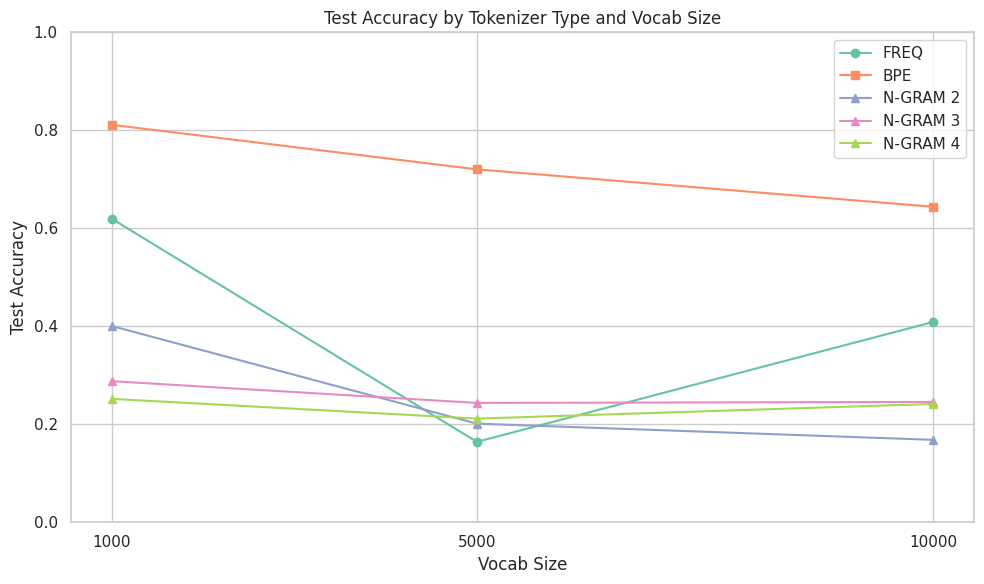

In [82]:
import matplotlib.pyplot as plt

# 결과 저장용
results = {
    'freq': [],
    'bpe': [],
    'n-gram': {n: [] for n in n_gram_idxs}
}

# FREQ 결과 저장
for vs in vocab_sizes:
    model = model_dict['freq'][vs]
    test_loader = test_loader_dict['freq'][vs]
    acc = evaluate_model(model, test_loader)
    results['freq'].append(acc)
    print(f"[FREQ] vocab_size={vs} → Test Accuracy: {acc:.4f}")

# N-GRAM 결과 저장
for n in n_gram_idxs:
    for vs in vocab_sizes:
        model = model_dict['n-gram'][n][vs]
        test_loader = test_loader_dict['n-gram'][n][vs]
        acc = evaluate_model(model, test_loader)
        results['n-gram'][n].append(acc)
        print(f"[N-GRAM {n}] vocab_size={vs} → Test Accuracy: {acc:.4f}")

# BPE 결과 저장
for vs in vocab_sizes:
    model = model_dict['bpe'][vs]
    test_loader = test_loader_dict['bpe'][vs]
    acc = evaluate_model(model, test_loader)
    results['bpe'].append(acc)
    print(f"[BPE] vocab_size={vs} → Test Accuracy: {acc:.4f}")

# 시각화
plt.figure(figsize=(10, 6))

# FREQ
plt.plot(vocab_sizes, results['freq'], marker='o', label='FREQ')

# BPE
plt.plot(vocab_sizes, results['bpe'], marker='s', label='BPE')

# N-GRAM
for n in n_gram_idxs:
    plt.plot(vocab_sizes, results['n-gram'][n], marker='^', label=f'N-GRAM {n}')

plt.title('Test Accuracy by Tokenizer Type and Vocab Size')
plt.xlabel('Vocab Size')
plt.ylabel('Test Accuracy')
plt.xticks(vocab_sizes)
plt.ylim(0, 1.0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
